# How to Create an Image Classifer

> This tutorial shows you how to build an image classifer to detect whether an image is a Labrador or a Golden Retriever using fastai

## Collect Data

To train our classfier, we need images of Labrador and Golden Retriever. Luckily, we can easily get the images from the web. We will use DockDockGo to download the images.

In [ ]:
from duckduckgo_search import ddg_images

Let's try using ddg_images to download an image and see what it returns.

In [ ]:
result = ddg_images('Labrador', max_results=1)
result

[{'title': 'British Labrador - 15 fascinating facts that you should know - DOGS & CATS HQ',
  'image': 'https://dogsandcatshq.com/wp-content/uploads/2020/08/labrador-retriever-4446566_1920-1536x1152.jpg',
  'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.a5F_IVmQ42Zc7CwzsIDLXAHaFj&pid=Api',
  'url': 'https://dogsandcatshq.com/15-facts-to-know-about-british-labrador-1593',
  'height': 1152,
  'width': 1536,
  'source': 'Bing'}]

We got a list back. This list contains one dictionary represeting one image. The part we need is the image URL. fastai's L class is like a python list but adds useful functions to make working with list easier. One of the useful function is itemgot which allows you to get the image URL from the dictionary. 

In [ ]:
from fastcore.all import *
URL = L(result).itemgot('image')
URL

(#1) ['https://dogsandcatshq.com/wp-content/uploads/2020/08/labrador-retriever-4446566_1920-1536x1152.jpg']

Now we have the URL, we can download the image and see what it looks like. fastdownload provides a useful function called download_url which allows you to download a file from the Internet. We will use this function to download the image.

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extensio

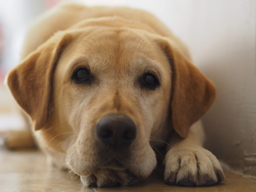

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

dest = Path('../images/Labrador_and_Golden_Retriever_Classifier/Labrador/lab.jpg')
download_url(URL[0], dest)
Image.open(dest).to_thumb(256,256)

We created a path for the downloaded image and passed the path and the image URL to download_url. Once the image is downloaded, we used Image from PIL to open the image. The to_thumb function is added by fastai to resize an image. I used it to make the image smaller so the output takes less space. The image looks good. We can use the same procedure to download more Labrador and Golden Retriever iamges. To make our life easier, we will create a function to combine ddg_images and extracting the image URLs. 

In [ ]:
def search_images(term, max_results=50):
    return L(ddg_images(term, max_results = max_results)).itemgot('image')

Now we will download more images

In [ ]:
# First download Labrador images
dest = Path('../images/Labrador_and_Golden_Retriever_Classifier/Labrador')
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images('Labrador', max_results=100))

# Then download Golden Retriever images
dest = Path('../images/Labrador_and_Golden_Retriever_Classifier/Golden_Retriever')
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images('Golden Retriever', max_results=100))

Instead of using download_url to download the images, I used download_images. download_images is a function from fastai to download a list of images into a directory. Since we are dealing with many images, using download_images is more convenient. download_images only works if the destination directory already exists hence we need to create the directory before calling download_iamges. Passing parents=True to create all the neccessory parent directories. Passing exist_ok = True to avoid getting an exception if the directories already exsit. I put all the Labrador images into the Labrador directory and all Golden Retriever images into a Golden_Retriever directory. This is a common way of organizing data and will make our traning job easier as fastsi provides ways to label our data if we organize our data this way. 

Let's do a sanity check to make sure we don't have broken images. 

In [ ]:
path = Path('../images/Labrador_and_Golden_Retriever_Classifier')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Here we check for any broken images and remove them. Looks like we have one image that can't be open. Luckily that we have removed it from our dataset. 

## Train Our Model

Now we have our data, the next step is to train our model. We need a dataloader that can feed data to our model in batches. The most flexible way to create a dataloader is to using a DataBlock

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter = RandomSplitter(valid_pct=0.2, seed=30),
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
).dataloaders(path, bs=32)

There is a lot of information above, so let's unpack it.  

We created our dataloaders from a DataBlock. This is the most flexible way to create a dataloaders object. DataBlock is a call from fastai. You can think of a Datablock as a Dataset. In fact, DataBlock is a class that wraps around PyTorch's Dataset class. The blocks parameter tells the input data type and output data type of our model. Here our input is images so we use ImageBlock. Our output is a categorical label (e.g. Labrador or Golder Retriever), so we use CategoryBlock. 

get_items tells fastai how to find our data. Here we use the get_image_files function which is also provided by fastai to get all the images recursively in the directory defined by our path variable. 

Similarly get_y tells fastai how we want to label our data. Passing parent_label means we get the label for each image from the parent directory. Now you see why we organized our Labrador images and Golden Retriever images into the Labrador and Golder_Retriever directory because it allows us to easily get the label of our data. 

spliter defines how we want to split our data. Here we use a 80/20 percent split (80% training data and 20% validation data). Setting the seed allows us to get the same split every time. 

item_tfms allows us to do preprocessing on each image before passing to our model. Our model expects every image to be the same size but our images are downloaded from the Internet hence their sizes are different. Our final desired image size is 224 px x 224 px but we resized our image to a larger size (460 px x 460 px) so that when performing augmentation, we won't have any empty space.  

batch_tfms performs augmentation on a whole batch. We use augmentation to ulter our images (e.g. rotate, zoom, warp, etc) so that our model can recognize images even if they are not perfectly taken. fastai performs all the transforms together with a single interpolation at the end to improve the quality of the augmented images. Doing augmentation on the whole batch instead of on each image one by one can improve the performance. 

Lastly, after our DataBlock is define, we used the dataloaders function to create our dataloades. Note the plural form in the function name. The dataloaders object actually have two dataloaders: one for the training data and one for the validation data. 

Let's see some images from our dataloaders.

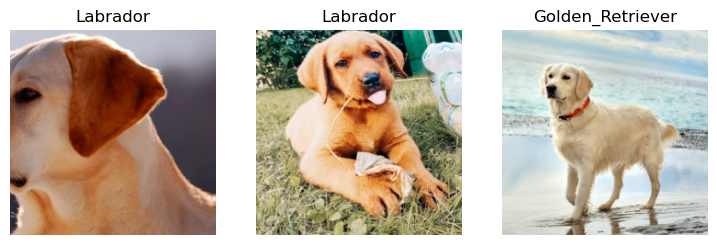

In [ ]:
dls.show_batch(max_n=3)

Looking good. Now we have our dataloaders. It is time to create our learner and train our model.

In [ ]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.083923,0.330193,0.081081,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.478743,0.215766,0.081081,00:42
1,0.323527,0.146788,0.054054,00:42
2,0.256091,0.159724,0.054054,00:41
3,0.196183,0.199050,0.081081,00:48
4,0.156227,0.217985,0.081081,00:44


With 5 epoc, our model has a 8% error. It is good to see where our model is making wrong preditions. A confusion matrix can tell us just that. 

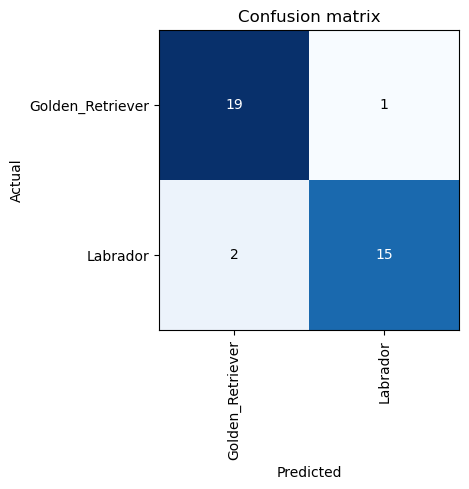

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

One Golden Retriever image and two Labrador images were predicted incorrectly. We can sort our images by loss and see why our model was making incorrect preditions on those images. 

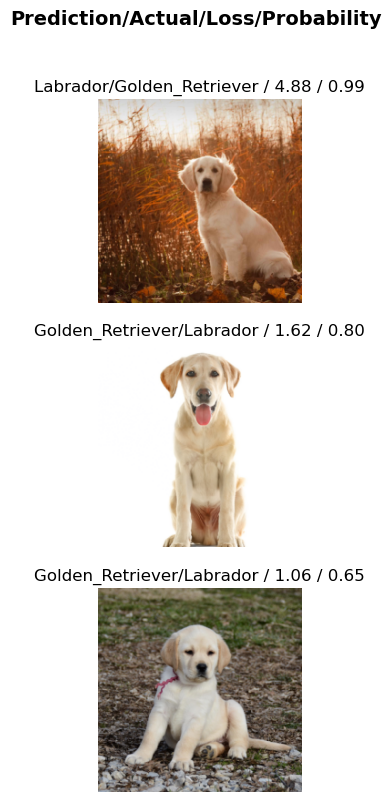

In [ ]:
interp.plot_top_losses(3, nrows=3)

The first picture looks like a Golden Retriever and the secomd picture looks like a Labrador to me. It could be our labels are wrong. The last image is a puppy which is very hard to tell whether it is a Golden Retriever or a Labrador. By looking at these pictures, our model's performance is acutally pretty good. 

Now we have a model. It is time to use it for prediction. 

## Deploy Our Model

We can't expect our users to use Jupyter Notebook, so we need to export our model and host it on the web. 

In [ ]:
learner.export('model.pkl')

We have exported our model into a model.pkl file. Next we need to host our model on a web service, so others can use it. In this tutorial, we will use Hugging Face to host our model. 

First, we need to create a new space on Hugging Face.
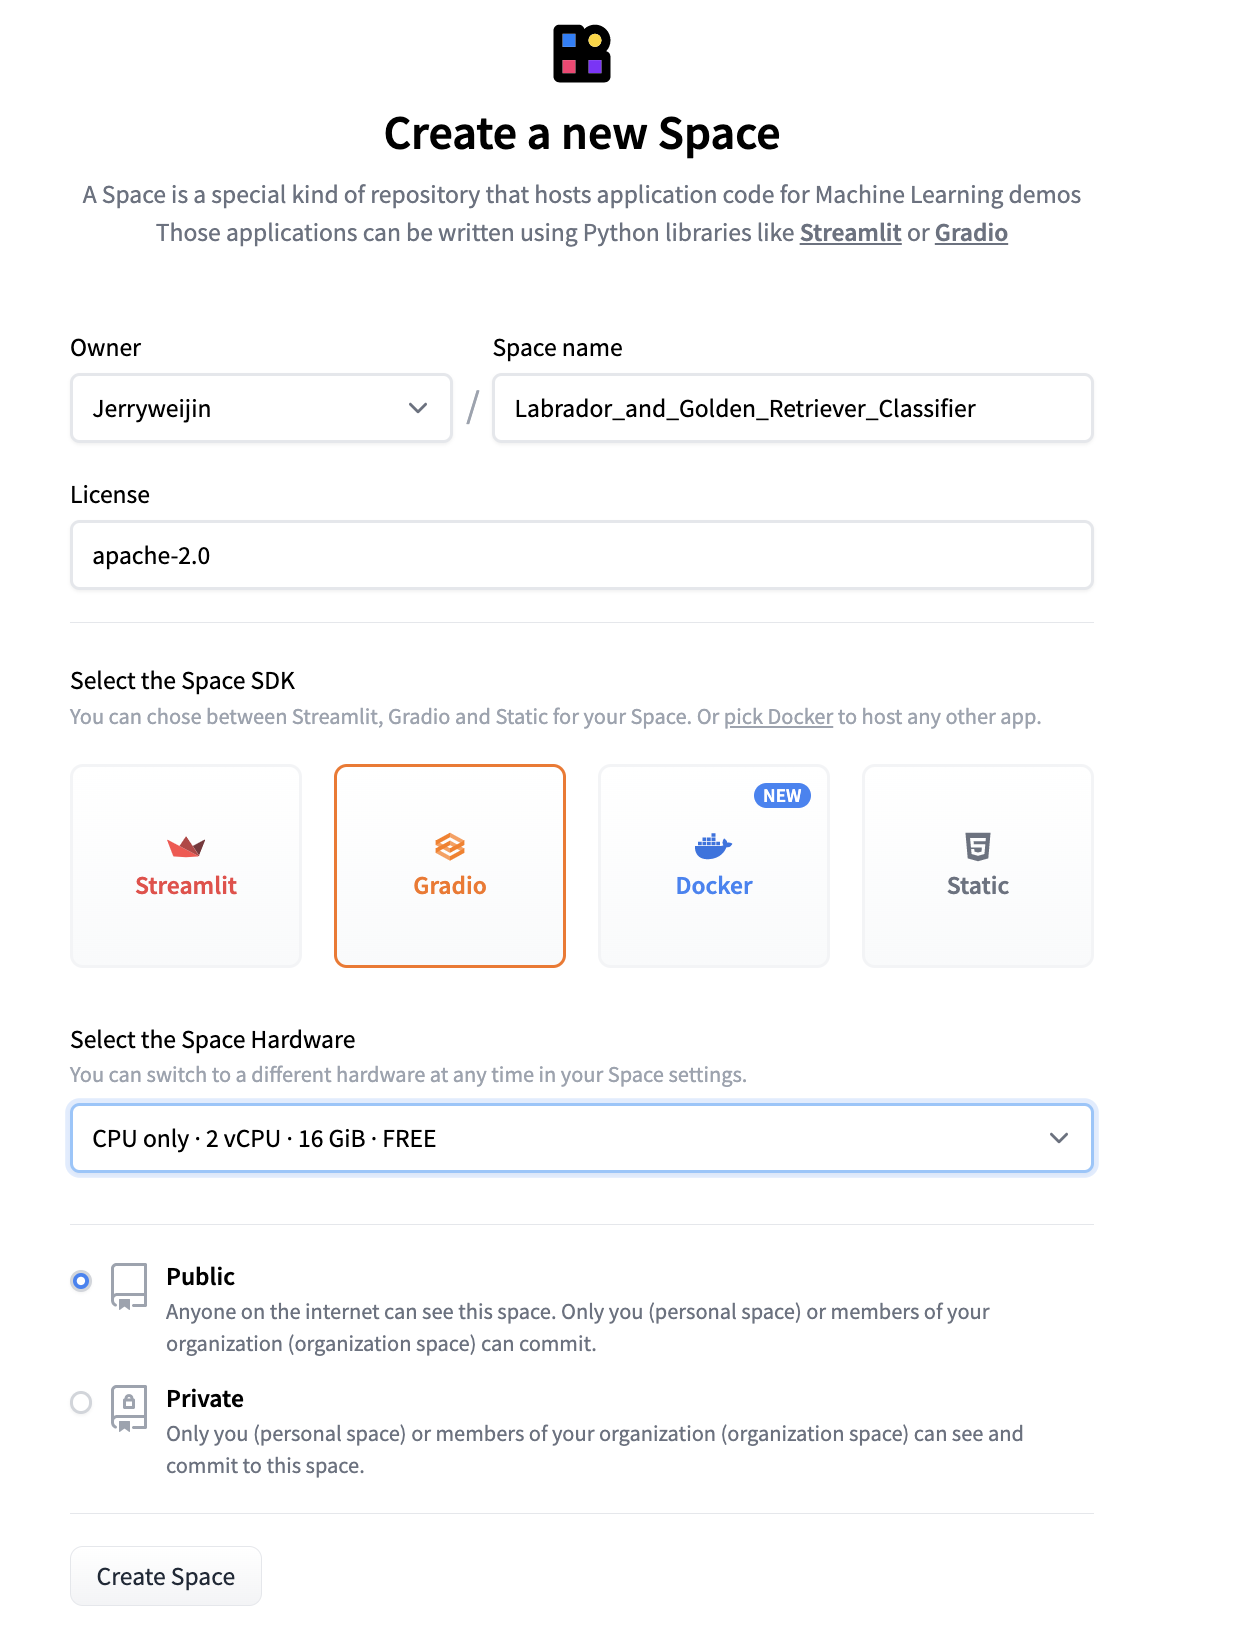

Next we need to clone this space to our local computer. 

In [ ]:
git clone https://huggingface.co/spaces/Jerryweijin/Labrador_and_Golden_Retriever_Classifier

Once the space is cloned, copy the model.pkl file to the Hugging Face diretory. We will need to upload our model along with other files to Hugging Face.

Next, we need to create an app.py file in the Hugging Face directory. This is the file that runs our model, presents an UI to our users, and display the predition result. If you are a web developer, you can use HTML and Javascript to build whatever UI you want, but since I am not, I will use Gradio to build the UI.

In [ ]:
# app.py
from fastai.vision.all import *
import gradio as gr

# Load our model
learn = load_learner('model.pkl')

# A function to call when an image is submited
categories=('Golden Retriever', 'Labrador')
def predict(img):
    pred,idx,prob = learn.predict(img)
    return dict(zip(categories, map(float, prob)))

# Define a gradio interface
image = gr.inputs.Image((224,224)) # Input to our model is an image
label = gr.outputs.Label() # Output of our model is a label

# Gradio will build the UI for users to upload an image and display the prediction result 
interface = gr.Interface(fn=predict, inputs=image, outputs=label)
interface.launch()

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extensio

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Lastly, we need a requirement.txt file. Hugging Face will look at this file and install all the required packages for us. For this project, we only need to install fastai, so our requirement.txt file only has one item.

In [ ]:
# requirements.txt
fastai

You Hugging Face directory now should have 3 files: model.pkl, app.py, and requirement.txt. Commit the changes and push the files to Hugging Face space. 

In [ ]:
git commit -m "Initial Commit"
git push

Now go to the Hugging Face space and you should see the app is being built. Once building is completed, you will see your app running on Hugging Face. Try to upload a new image and see your model work in a live environment. 

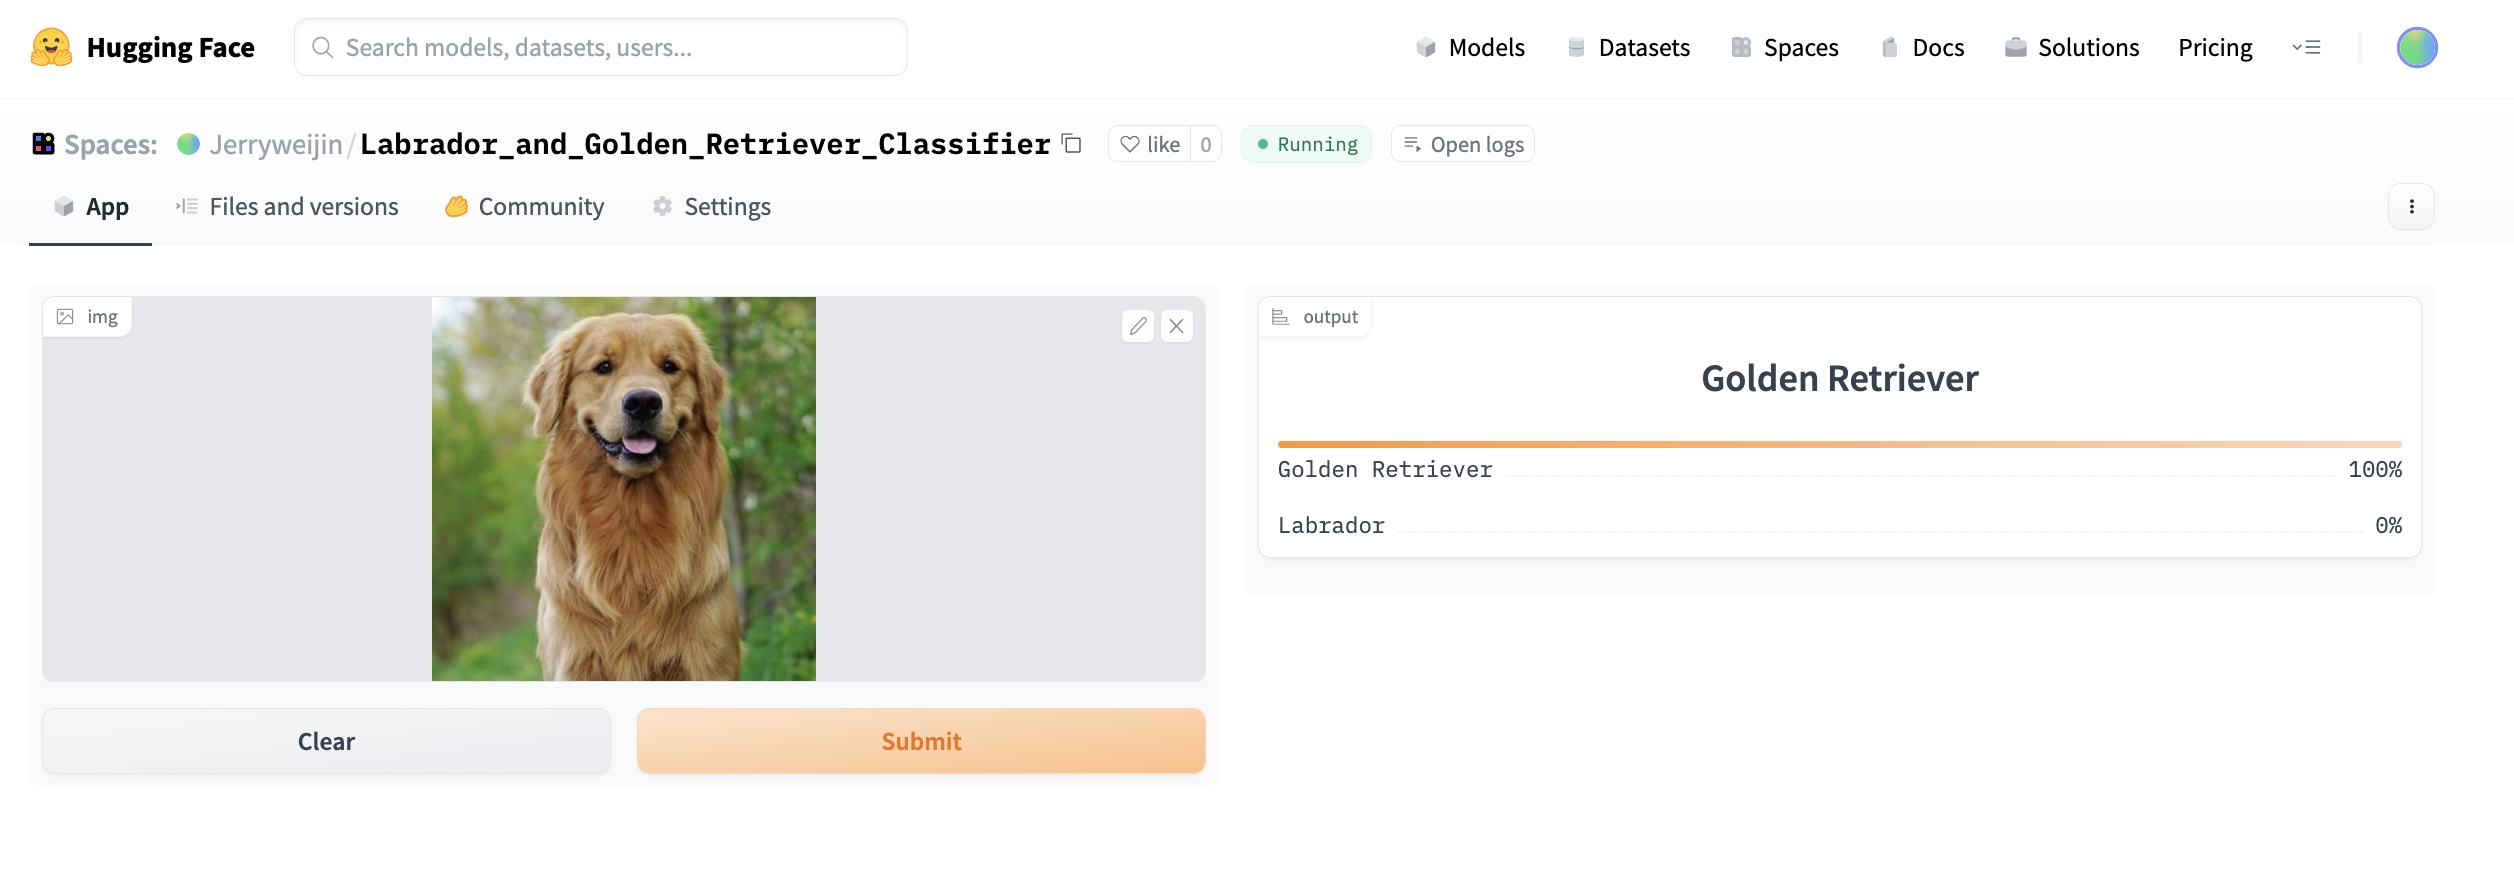

In this tutorial, I have shown how to build a simple binary image classifier using fastai and host the model on Hungging Face. In the next tutorial, we will expand on this model to do multi-class classification. We will classify pet breeds.